# 1. Load & Inspect Dataset

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/Sepsis Prediction.csv")

print(df.info())
display(df.head())

print("\nTarget distribution:")
print(df["SepsisLabel"].value_counts())
print(df["SepsisLabel"].value_counts(normalize=True))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94555 entries, 0 to 94554
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        94555 non-null  int64  
 1   Hour              94555 non-null  int64  
 2   HR                87099 non-null  float64
 3   O2Sat             83034 non-null  float64
 4   Temp              32170 non-null  float64
 5   SBP               79883 non-null  float64
 6   MAP               84717 non-null  float64
 7   DBP               50269 non-null  float64
 8   Resp              84971 non-null  float64
 9   EtCO2             0 non-null      float64
 10  BaseExcess        9681 non-null   float64
 11  HCO3              7606 non-null   float64
 12  FiO2              13232 non-null  float64
 13  pH                10680 non-null  float64
 14  PaCO2             8144 non-null   float64
 15  SaO2              4590 non-null   float64
 16  AST               1371 non-null   float6

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072



Target distribution:
SepsisLabel
0    92422
1     2133
Name: count, dtype: int64
SepsisLabel
0    0.977442
1    0.022558
Name: proportion, dtype: float64


#2. Basic Cleaning & Separation

In [6]:
df = df.drop(columns=["Unnamed: 0", "EtCO2"])

y = df["SepsisLabel"]
patient_ids = df["Patient_ID"]

X = df.drop(columns=["SepsisLabel", "Patient_ID"])



#3. Patient-Level Feature Aggregation

In [7]:
df_model = X.copy()
df_model["SepsisLabel"] = y
df_model["Patient_ID"] = patient_ids

agg_funcs = ["mean", "max", "min"]

patient_features = (
    df_model
    .groupby("Patient_ID")
    .agg({col: agg_funcs for col in X.columns})
)

patient_features.columns = [
    f"{col}_{stat}" for col, stat in patient_features.columns
]

patient_labels = (
    df_model
    .groupby("Patient_ID")["SepsisLabel"]
    .max()
)

X_patient = patient_features
y_patient = patient_labels

print(X_patient.shape)
print(y_patient.value_counts(normalize=True))


(2423, 120)
SepsisLabel
0    0.908378
1    0.091622
Name: proportion, dtype: float64


#4. Patient-Level Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_patient,
    y_patient,
    test_size=0.25,
    stratify=y_patient,
    random_state=42
)


#5. Missingness Indicators + Imputation

In [9]:
from sklearn.impute import SimpleImputer

# Missing indicators (vectorised, no fragmentation)
X_train_missing = X_train.isna().astype(int)
X_test_missing = X_test.isna().astype(int)

X_train_missing.columns = [c + "_missing" for c in X_train.columns]
X_test_missing.columns = [c + "_missing" for c in X_test.columns]

# Median imputation
imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imp = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Final matrices
X_train_final = pd.concat([X_train_imp, X_train_missing], axis=1)
X_test_final = pd.concat([X_test_imp, X_test_missing], axis=1)

print(X_train_final.shape, X_test_final.shape)
print("NaN left:", X_train_final.isna().any().any())



(1817, 240) (606, 240)
NaN left: False


# Baseline Model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_final, y_train)

y_test_prob = log_reg.predict_proba(X_test_final)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, (y_test_prob >= 0.5).astype(int)))


ROC-AUC: 0.7818181818181819
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       550
           1       0.21      0.55      0.30        56

    accuracy                           0.76       606
   macro avg       0.58      0.67      0.58       606
weighted avg       0.88      0.76      0.80       606



# 7. Threshold Tuning

In [11]:
from sklearn.metrics import recall_score, precision_score

for t in np.arange(0.1, 0.51, 0.05):
    preds = (y_test_prob >= t).astype(int)
    print(
        f"t={t:.2f}",
        "recall:", recall_score(y_test, preds),
        "precision:", precision_score(y_test, preds)
    )



t=0.10 recall: 0.9642857142857143 precision: 0.13012048192771083
t=0.15 recall: 0.9464285714285714 precision: 0.14804469273743018
t=0.20 recall: 0.9107142857142857 precision: 0.16346153846153846
t=0.25 recall: 0.8392857142857143 precision: 0.17537313432835822
t=0.30 recall: 0.7678571428571429 precision: 0.17842323651452283
t=0.35 recall: 0.7321428571428571 precision: 0.1943127962085308
t=0.40 recall: 0.6607142857142857 precision: 0.20555555555555555
t=0.45 recall: 0.5892857142857143 precision: 0.2
t=0.50 recall: 0.5535714285714286 precision: 0.2052980132450331


#8. XGBoost (Final Model)

In [14]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report


X_test_final = X_test_final[X_train_final.columns]

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)


xgb_model.fit(X_train_final, y_train)


y_test_prob = xgb_model.predict_proba(X_test_final)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))

threshold = 0.30
final_preds = (y_test_prob >= threshold).astype(int)

print(classification_report(y_test, final_preds))


ROC-AUC: 0.9139285714285714
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       550
           1       0.80      0.64      0.71        56

    accuracy                           0.95       606
   macro avg       0.88      0.81      0.84       606
weighted avg       0.95      0.95      0.95       606



# 9. SHAP Explainability

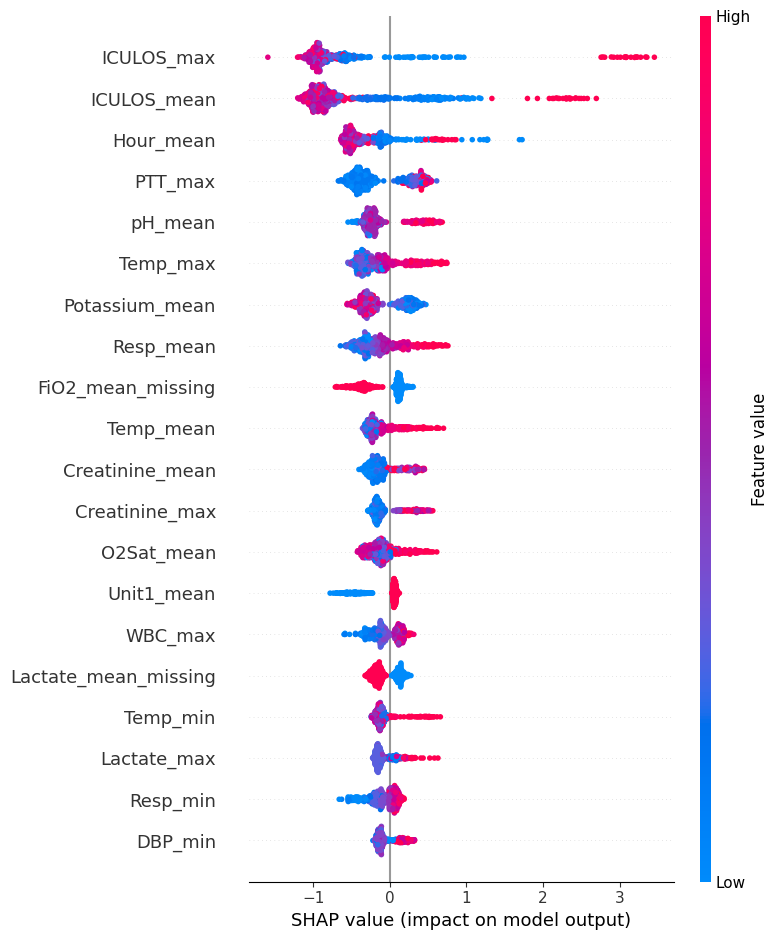

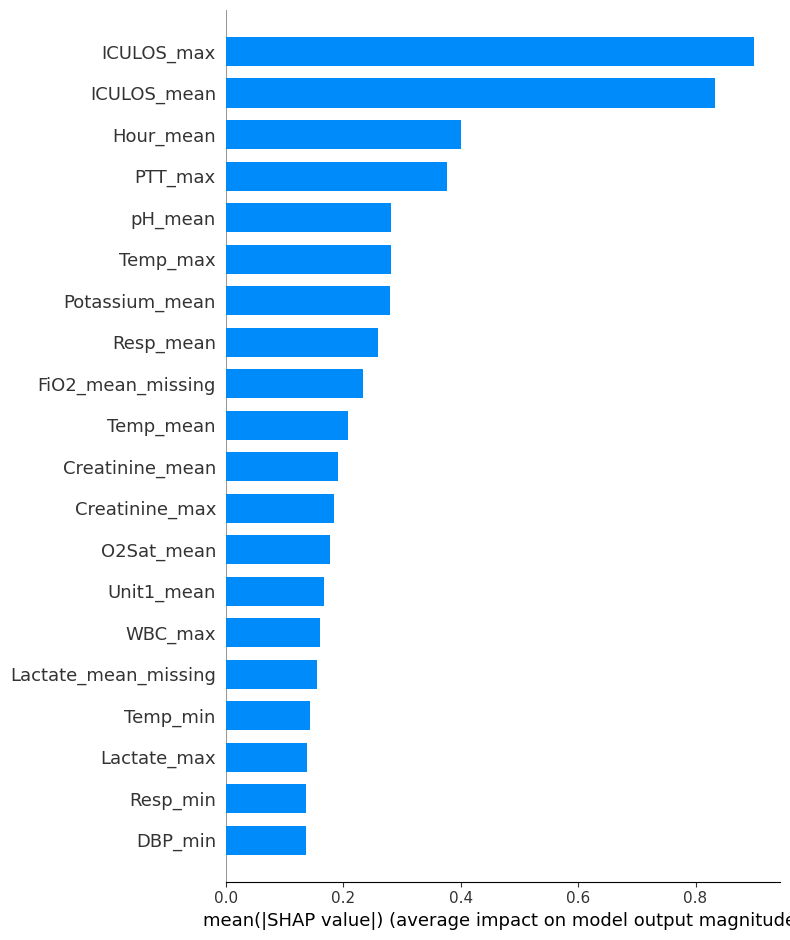

In [15]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_final)


shap.summary_plot(
    shap_values,
    X_test_final,
    show=True
)


shap.summary_plot(
    shap_values,
    X_test_final,
    plot_type="bar",
    show=True
)


plt.figure()
shap.summary_plot(shap_values, X_test_final, show=False)
plt.savefig("shap_beeswarm.png", bbox_inches="tight", dpi=300)
plt.close()

plt.figure()
shap.summary_plot(shap_values, X_test_final, plot_type="bar", show=False)
plt.savefig("shap_bar.png", bbox_inches="tight", dpi=300)
plt.close()